# Exploring Hugging Face Model and Dataset APIs With `xaitk-saliency` Integration

This example demonstrates loading a subset of a dataset located on Hugging Face's hub and then using that data within an object detection "pipeline" to get predictions from a model hosted on Hugging Face's hub. This notebook will also explore one method of integrating Hugging Face and `xaitk-saliency` to generate saliency maps for model predictions.

## Table Of Contents
* [Environment Setup](#environment-setup)
* [Inspect and Load Dataset](#inspect-and-load-dataset)
* [Using Hugging Face's Pipeline for Model Predictions](#hugging-face-pipeline-predictions)
  * [Pipeline Setup](#pipeline-setup)
  * [Predicting With the Pipeline Directly](#predicting-with-pipeline-directly)
  * [Visualizing Pipeline Predictions](#visualizing-pipeline-predictions)
* [Hugging Face/XAITK Integration](#hugging-face-xaitk-integration)
  * [`DetectImageObjects` Implementation](#detect-image-objects-implementation)
  * [Instantiate Detector Object](#instantiate-detector-object)
  * [Get Predictions From the Detector Object](#predictions-from-detector-object)
  * [Visualize Predictions](#visualize-predictions)
  * [Generate Saliency Maps with `xaitk-saliency`](#generate-saliency-maps-with-xaitk-saliency)
    * [Prepare Inputs](#prepare-inputs)
    * [Saliency Generation Object](#saliency-generation-object)
    * [Saliency Map Generation](#saliency-map-generation)
    * [Saliency Map Visualization](#saliency-map-visualization)

## Environment Setup <a name="environment-setup"></a>

Here we install `datasets` and `transformers` from Hugging Face, as well as matplotlib for some quick visualization and `xaitk-saliency` for saliency map generation.

The model we will be using for this example utilizes PyTorch Image Models (`timm`) so we will also install that now. Note Python 3.7+ is required for PyTorch.

In [1]:
import sys
!{sys.executable} -m pip install -qU pip
print("Installing Hugging Face datasets...")
!{sys.executable} -m pip install -q datasets
print("Installing Hugging Face transformers...")
!{sys.executable} -m pip install -q transformers
print("Installing matplotlib...")
!{sys.executable} -m pip install -q matplotlib
print("Installing xaitk-saliency...")
!{sys.executable} -m pip install -q git+https://github.com/xaitk/xaitk-saliency.git
print("Installing timm...")
!{sys.executable} -m pip install -q timm
print("Done!")

Installing Hugging Face datasets...
Installing Hugging Face transformers...
Installing matplotlib...
Installing xaitk-saliency...
Installing timm...
Done!


## Inspect and Load Dataset <a name="inspect-and-load-dataset"></a>

Before loading the dataset, we can inspect it using `load_dataset_builder`. We'll be using a dataset of images from chapbooks held by the National Library of Scotland, the dataset card can be found [here](https://huggingface.co/datasets/biglam/nls_chapbook_illustrations "biglam/nls_chapbook_illustrations Dataset Card").

The first argument to the load dataset builder specifies the dataset we're interested in while the second specifies a subset of that particular dataset.

In [2]:
from datasets import load_dataset_builder

ds_builder = load_dataset_builder("biglam/nls_chapbook_illustrations", "illustration-detection")

In [3]:
# Inspect dataset description
ds_builder.info.description

'This dataset comprises of images from chapbooks held by the National Library of Scotland and digitised and published as its Chapbooks Printed in Scotland dataset'

In [4]:
# Inspect dataset features
ds_builder.info.features

{'image_id': Value(dtype='int64', id=None),
 'image': Image(decode=True, id=None),
 'width': Value(dtype='int32', id=None),
 'height': Value(dtype='int32', id=None),
 'objects': [{'category_id': ClassLabel(names=['early_printed_illustration'], id=None),
   'image_id': Value(dtype='string', id=None),
   'id': Value(dtype='int64', id=None),
   'area': Value(dtype='int64', id=None),
   'bbox': Sequence(feature=Value(dtype='float32', id=None), length=4, id=None),
   'segmentation': [[Value(dtype='float32', id=None)]],
   'iscrowd': Value(dtype='bool', id=None)}]}

We can then actually load the dataset, with the same arguments as before. Hugging Face will cache downloaded information to avoid unnecessarily downloading duplicate data.

In [5]:
from datasets import load_dataset

ds = load_dataset("biglam/nls_chapbook_illustrations", "illustration-detection")

Found cached dataset nls_chapbook_illustrations (/home/local/KHQ/emily.veenhuis/.cache/huggingface/datasets/biglam___nls_chapbook_illustrations/illustration-detection/1.0.0/bab1989ea05996f5c8c55e1c10c0209b2936cb1ec3faa2f89a7ed7cab0193ea4)


  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
# Inspect dataset structure
ds

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 7258
    })
})

We can see from inspecting the dataset (or looking at the dataset card) that this dataset only has a single split, `train`.

In [7]:
ds_train = ds["train"]

In [8]:
# Inspect example datum structure
ds_train[0]

{'image_id': 4,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x1080 at 0x7FCE9561BBB0>,
 'width': 600,
 'height': 1080,
 'objects': [{'category_id': 0,
   'image_id': '4',
   'id': 1,
   'area': 110901,
   'bbox': [34.529998779296875,
    556.8300170898438,
    401.44000244140625,
    276.260009765625],
   'segmentation': [[34.529998779296875,
     556.8300170898438,
     435.9700012207031,
     556.8300170898438,
     435.9700012207031,
     833.0900268554688,
     34.529998779296875,
     833.0900268554688]],
   'iscrowd': False}]}

In [9]:
# For this example, shuffle the dataset to look at random sampling of the data.
ds_train_shuffle = ds_train.shuffle(seed=0)

sample_idxs = [0,2,3]
num_predictions = len(sample_idxs)
ds_samples = [ds_train_shuffle[idx] for idx in sample_idxs]

Loading cached shuffled indices for dataset at /home/local/KHQ/emily.veenhuis/.cache/huggingface/datasets/biglam___nls_chapbook_illustrations/illustration-detection/1.0.0/bab1989ea05996f5c8c55e1c10c0209b2936cb1ec3faa2f89a7ed7cab0193ea4/cache-47a1184601205ace.arrow


In [10]:
# Create a mapping of labels/ids
id2label = dict(enumerate(ds_train.features["objects"][0]["category_id"].names))
label2id = {v: k for k, v in id2label.items()}

## Using Hugging Face's Pipeline for Model Predictions <a name="hugging-face-pipeline-predictions"></a>

Hugging Face gives users a "pipeline" for rapid prediction making using pre-trained models which we will be utilizing.

### Pipeline Setup <a name="pipeline-setup"></a>

`Auto` classes serve as generic classes that will be instantiated as one of the derived classes of the library. `Tokenizers` or, in the case of vision-based models, `FeatureExtractors` are used to get the data in the format the model expects. We're using `AutoModelForObjectDetection` which is specifically for models with an object detection head.

For this example, we will be using `biglam/detr-resnet-50_fine_tuned_nls_chapbooks` which is a version of the `facebook/detr-resnet50` model fine-tuned for the dataset we've loaded. The model card for this model can be found [here](https://huggingface.co/biglam/detr-resnet-50_fine_tuned_nls_chapbooks "biglam/detr-resnet-50_fine_tuned_nls_chapbooks Model Card").

In [11]:
from transformers import pipeline, AutoFeatureExtractor, AutoModelForObjectDetection

extractor = AutoFeatureExtractor.from_pretrained("biglam/detr-resnet-50_fine_tuned_nls_chapbooks")
model = AutoModelForObjectDetection.from_pretrained("biglam/detr-resnet-50_fine_tuned_nls_chapbooks")

Once we have our model and feature extractor, we can set up our pipeline.

In [12]:
obj_detection_pipe = pipeline("object-detection", model=model, feature_extractor=extractor)

### Predicting With the Pipeline Directly <a name="predicting-with-pipeline-directly"></a>

Simply provide data to this pipeline to get model predictions.

In [13]:
pipeline_dets = obj_detection_pipe([d['image'] for d in ds_samples])

# Inspect predictions
pipeline_dets

/home/local/KHQ/emily.veenhuis/Documents/xaitk-cdao/examples/huggingface/env/lib/python3.9/site-packages/transformers/models/detr/feature_extraction_detr.py:848: FutureWarning: `post_process` is deprecated and will be removed in v5 of Transformers, please use `post_process_object_detection`
  warnings.warn(


[[{'score': 0.996687114238739,
   'label': 'early_printed_illustration',
   'box': {'xmin': 40, 'ymin': 571, 'xmax': 359, 'ymax': 824}}],
 [{'score': 0.9962963461875916,
   'label': 'early_printed_illustration',
   'box': {'xmin': 71, 'ymin': 18, 'xmax': 439, 'ymax': 368}}],
 [{'score': 0.9954999089241028,
   'label': 'early_printed_illustration',
   'box': {'xmin': 30, 'ymin': 562, 'xmax': 482, 'ymax': 931}}]]

### Visualizing Pipeline Predictions <a name="visualizing-pipeline-predictions"></a>

We can write some `matplotlib` code to visualize these predictions.

In [14]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def show_pipeline_dets(ax, dets, thresh=0.5, show_labels=False):
    for idx, det in enumerate(dets):
        conf = det['score']
        if conf >= thresh:
            box = det['box']
            xmin, xmax, ymin, ymax = box['xmin'], box['xmax'], box['ymin'], box['ymax']
            label = det['label']

            ax.add_patch(Rectangle(
                (xmin, ymin),
                xmax - xmin,
                ymax - ymin,
                linewidth=1,
                edgecolor='r',
                facecolor='none'
            ))
            
            if show_labels:
                text = f'{label}: {conf:0.2f}'
                ax.text(xmin, ymin, text, color='b', fontsize=8)

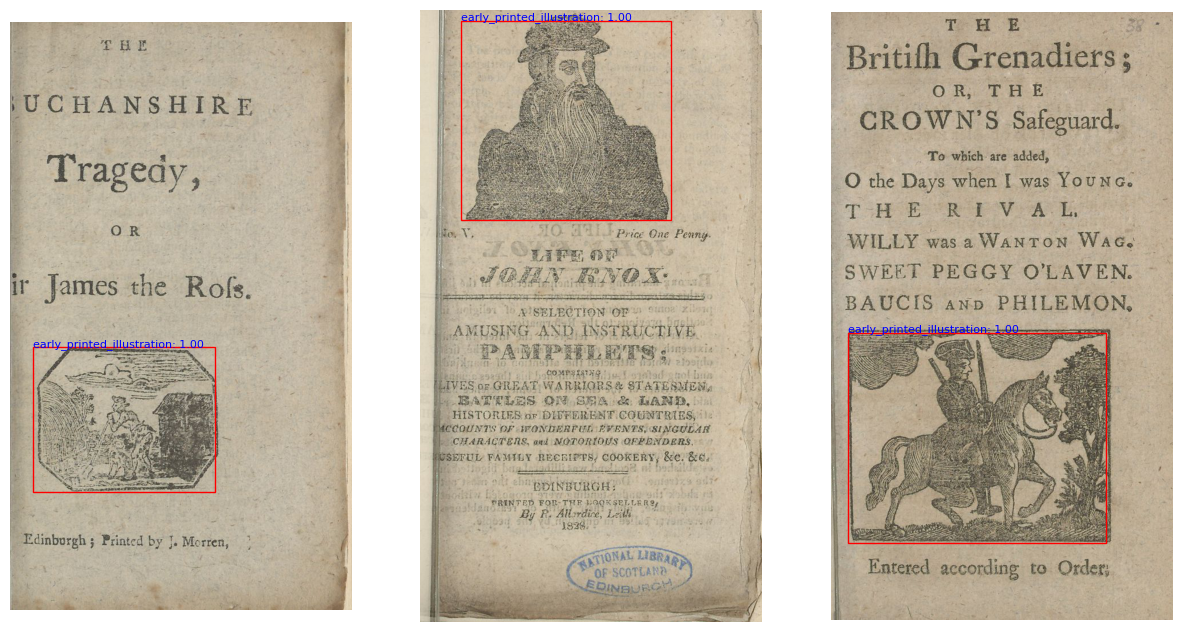

In [15]:
fig, axs = plt.subplots(1, num_predictions, figsize=(15, 15))
if num_predictions == 1:
    axs = [axs]

for idx, ax in enumerate(axs):
    ax.imshow(ds_samples[idx]['image'])
    ax.axis('off')
    show_pipeline_dets(ax, pipeline_dets[idx], thresh=0.4, show_labels=True)

## Hugging Face/XAITK Integration <a name="hugging-face-xaitk-integration"></a>

### `DetectImageObjects` Implementation <a name="detect-image-objects-implementation"></a>

To use the selected model with the `GenerateObjectDetectorBlackboxSaliency` interface, we need to create an implementation of `DetectImageObjects` that wraps the underlying model. The core method that requires implementation is `detect_objects()` which takes images and returns predictions for each image in the formated defined by the interface.

In [16]:
#smqtk imports
from smqtk_detection import DetectImageObjects
from smqtk_detection.utils.bbox import AxisAlignedBoundingBox

#Hugging Face imports
from transformers import pipeline, AutoFeatureExtractor, AutoModelForObjectDetection

import numpy as np
from typing import Iterable, Dict, Hashable, Tuple
from PIL import Image

class HuggingFaceObjectDetector(DetectImageObjects):
    def __init__(
        self,
        model,
        feature_extractor,
    ):
        self.model = model
        self.extractor = feature_extractor
        self.obj_detection_pipe = pipeline("object-detection", model=self.model, feature_extractor=self.extractor)
    
    def detect_objects(
        self,
        img_iter: Iterable[np.ndarray]
    ) -> Iterable[Iterable[Tuple[AxisAlignedBoundingBox, Dict[Hashable, float]]]]:
        preds = []
        
        for img in list(img_iter):
            # Hugging Face expects images to be in PIL format
            img_pil = Image.fromarray(img)
            detections = self.obj_detection_pipe(img_pil)
            
            preds.append(pred_to_list(detections))
            
        return preds
    
    # requried by interface
    def get_config(self):
        return {}
    
def pred_to_list(preds):
    """
    Convert prediction to AxisAlignedBoundingBox format.
    """
    pred_list = []

    for pred in preds:
        box = pred['box']
        bbox = AxisAlignedBoundingBox([box['xmin'], box['ymin']], [box['xmax'], box['ymax']])

        score_dict = dict.fromkeys(id2label.keys(), 0)
        score_dict[label2id[pred['label']]] = pred['score']

        pred_list.append((bbox, score_dict))

    return pred_list

### Instantiate Detector Object <a name="instantiate-detector-object"></a>

In [17]:
model = AutoModelForObjectDetection.from_pretrained("biglam/detr-resnet-50_fine_tuned_nls_chapbooks")
extractor = AutoFeatureExtractor.from_pretrained("biglam/detr-resnet-50_fine_tuned_nls_chapbooks")
nls_chapbook_detector = HuggingFaceObjectDetector(model, extractor)

### Get Predictions From the Detector Object <a name="predictions-from-detector-object"></a>

In [18]:
import time

print("Getting image predictions...")
imgs = [np.array(d['image']) for d in ds_samples]
start = time.time()
dets = nls_chapbook_detector(imgs)
end = time.time()
print(f"Done in {end-start:.2f}s")

Getting image predictions...


/home/local/KHQ/emily.veenhuis/Documents/xaitk-cdao/examples/huggingface/env/lib/python3.9/site-packages/transformers/models/detr/feature_extraction_detr.py:848: FutureWarning: `post_process` is deprecated and will be removed in v5 of Transformers, please use `post_process_object_detection`
  warnings.warn(


Done in 2.55s


### Visualize Predictions <a name="visualize-predictions"></a>

In [19]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def show_dets(ax, dets, thresh=0.5, show_labels=False):
    for i, det in enumerate(dets):
        score_dict = det[1]
        cls_idx = max(score_dict, key=score_dict.get)
        conf = score_dict[cls_idx]
        
        if conf >= thresh:
            bbox = det[0]
            x1, y1 = bbox.min_vertex
            x2, y2 = bbox.max_vertex
            ax.add_patch(Rectangle(
                (x1, y1),
                x2 - x1,
                y2 - y1,
                linewidth=1,
                edgecolor='r',
                facecolor='none'
            ))

            if show_labels:
                label=f'{id2label[cls_idx]} {conf:.2f}'
                ax.text(x1, y1 - 2, label, color='b', fontsize=8)

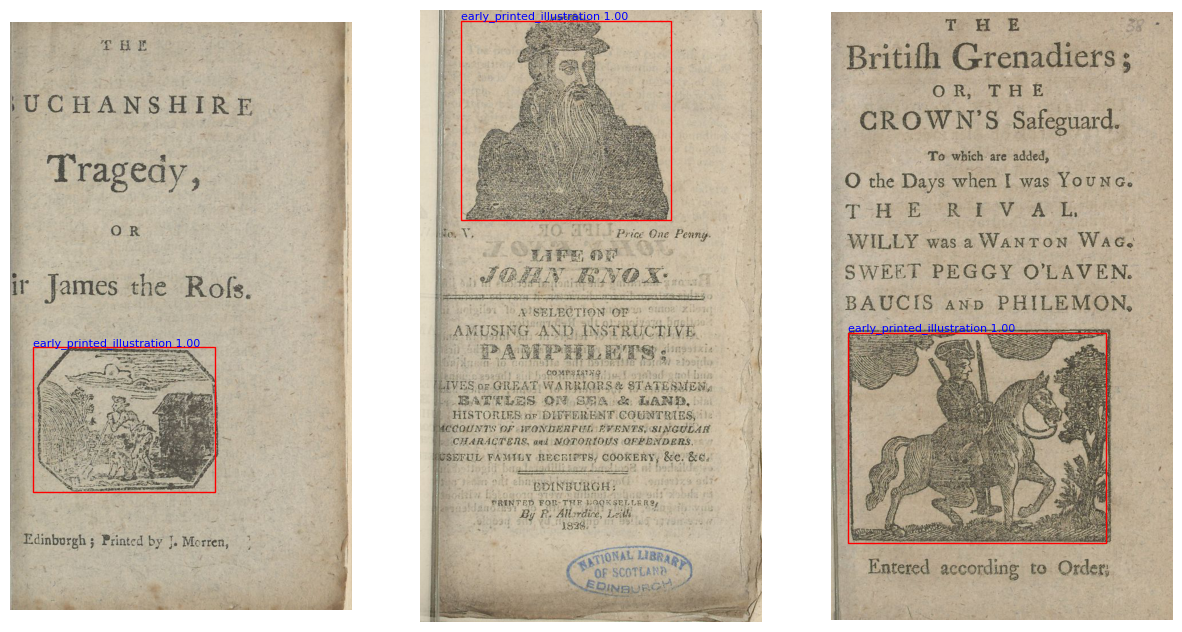

In [20]:
fig, axs = plt.subplots(1, num_predictions, figsize=(15, 15))
if num_predictions == 1:
    axs = [axs]

for idx, ax in enumerate(axs):
    ax.imshow(imgs[idx])
    ax.axis('off')
    show_dets(ax, dets[idx], thresh=0.4, show_labels=True)

### Generate Saliency Maps With `xaitk-saliency` <a name="generate-saliency-maps-with-xaitk-saliency"></a>

#### Prepare Inputs <a name="prepare-inputs"></a>

The `GenerateObjectDetectorBlackboxSaliency` interface requires our reference detections to be split into separate bounding boxes and scores inputs, both as numpy arrays.

In [21]:
import numpy as np

def dets_to_mats(dets):
    if not dets:
        return np.empty(0), np.empty(0)
    
    # use labels from first prediction to access all of them in a constant order
    labels = list(dets[0][1].keys())
    
    bboxes = np.empty((0, 4))
    scores = np.empty((0, len(labels)))
    for det in dets:
        bbox = det[0]
        
        bboxes = np.vstack((
            bboxes,
            [*bbox.min_vertex, *bbox.max_vertex,]
        ))

        score_dict = det[1]
        score_array = []
        for l in labels:
            score_array.append(score_dict[l])
            
        scores = np.vstack((
            scores,
            score_array,
        ))
    
    return bboxes, scores

In [22]:
bboxes = []
scores = []
for det in dets:
    b, s = dets_to_mats(det)
    bboxes.append(b)
    scores.append(s)

#### Saliency Generation Object <a name="saliency-generation-object"></a>

Here we will instantiate our `GenerateObjectDetectorBlackboxSaliency` implementation that combines image pertubation and detector-based saliency map generation into one call.

We will use `DRISEStack` which is comprised of the `RISEGrid` and `DRISEScoring` image pertubation and saliency map generation methods, respectively.

We will also set the saliency generator to use a gray fill to increase saliency map quality. This fill represents the average channel intensities of the dataset.

In [23]:
from xaitk_saliency.impls.gen_object_detector_blackbox_sal.drise import DRISEStack

sal_generator = DRISEStack(200, 8, 0.5, seed=0, threads=4)

# Dataset gray average
fill = [157, 144, 121]
sal_generator.fill = fill

#### Saliency Map Generation <a name="saliency-map-generation"></a>

In [24]:
import time
sal_maps = []
for idx in range(num_predictions):
    print("Generating saliency maps for image {} of {}...".format(idx + 1, num_predictions))
    start = time.time()
    sal_maps.append(
        sal_generator(
            imgs[idx],
            bboxes[idx],
            scores[idx],
            nls_chapbook_detector
    ))
    end = time.time()
    print(f"Done in {end-start:.2f}s")

Generating saliency maps for image 1 of 3...
Done in 186.25s
Generating saliency maps for image 2 of 3...


/home/local/KHQ/emily.veenhuis/Documents/xaitk-cdao/examples/huggingface/env/lib/python3.9/site-packages/transformers/models/detr/feature_extraction_detr.py:848: FutureWarning: `post_process` is deprecated and will be removed in v5 of Transformers, please use `post_process_object_detection`
  warnings.warn(


Done in 177.66s
Generating saliency maps for image 3 of 3...


/home/local/KHQ/emily.veenhuis/Documents/xaitk-cdao/examples/huggingface/env/lib/python3.9/site-packages/transformers/models/detr/feature_extraction_detr.py:848: FutureWarning: `post_process` is deprecated and will be removed in v5 of Transformers, please use `post_process_object_detection`
  warnings.warn(


Done in 178.40s


#### Saliency Map Visualization <a name="saliency-map-visualization"></a>

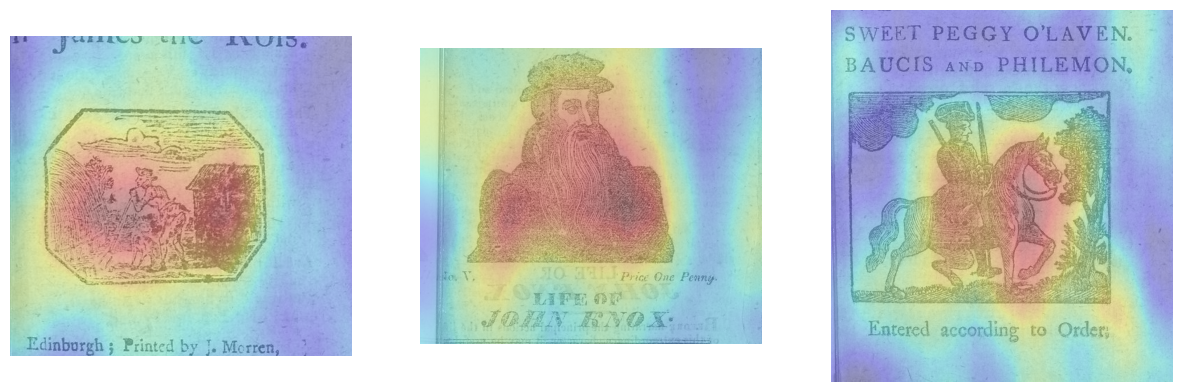

In [25]:
import matplotlib.pyplot as plt

gray_img = [np.asarray(Image.fromarray(img).convert("L")) for img in imgs]
pad_perc = 0.4

n_rows = max([len(x) for x in sal_maps])
n_cols = len(sal_maps)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15,15), squeeze = False)

for det_idx in range(n_rows):
    for img_idx in range(n_cols):
        ax = axs[det_idx][img_idx]
        try:
            sal_map = sal_maps[img_idx][det_idx]
        except IndexError:
            ax.axis('off')
            continue

        x1, y1, x2, y2 = bboxes[img_idx][det_idx]
        pad_x = pad_perc * (x2 - x1)
        pad_y = pad_perc * (y2 - y1)
        x1 = max(int(x1 - pad_x),0)
        y1 = max(int(y1 - pad_y), 0)
        x2 = int(x2 + pad_x)
        y2 = int(y2 + pad_y)

        img_crop = gray_img[img_idx][y1:(y2+1), x1:(x2+1)]
        sal_crop = sal_map[y1:(y2+1), x1:(x2+1)]

        ax.imshow(img_crop, alpha=0.7, cmap='gray')
        ax.imshow(sal_crop, alpha=0.3, cmap='jet')
        ax.axis('off')